# Inference

In [2]:
using Distributions
using PGFPlots
using BayesNets

## Inference for Classification

In [3]:
b = BayesNet()

In [4]:
# Set uniform prior over Class
push!(b, StaticCPD(:Class, NamedCategorical(["bird", "aircraft"], [0.5, 0.5])))

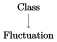

In [5]:
fluctuationStates = ["low", "hi"]
fluctuationDistributions(a::Assignment) = a[:Class] == "bird" ? NamedCategorical(fluctuationStates, [0.1, 0.9]) : 
                                                                NamedCategorical(fluctuationStates, [0.9, 0.1])
push!(b, FunctionalCPD{NamedCategorical}(:Fluctuation, [:Class], fluctuationDistributions))

In [6]:
# Function for plotting CPDs (don't worry about details here)
function plotCPD(cpd::CPD, range::Tuple{Real,Real}, assignments)
    convertAssignmentToString(a) = string(["$k = $v, " for (k,v) in a]...)[1:end-2]
    Axis(Plots.Plot[Plots.Linear(x->pdf(cpd(a), x), range, legendentry=convertAssignmentToString(a)) for a in assignments], width="25cm", height="8cm")
end;

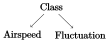

In [7]:
# if Bird, then Airspeed ~ N(45,10)
# if Aircraft, then Airspeed ~ N(100,40)
airspeedDistributions(a::Assignment) = a[:Class] == "bird" ? Normal(45,10) : Normal(100,40)
push!(b, FunctionalCPD{Normal}(:Airspeed, [:Class], airspeedDistributions))

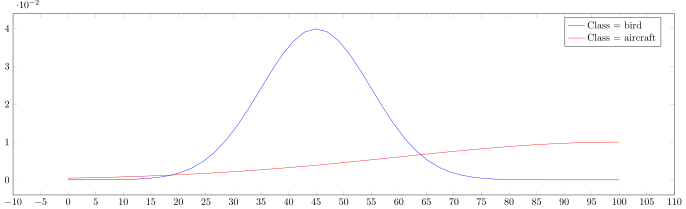

In [8]:
plotCPD(get(b, :Airspeed), (0., 100.), [Assignment(:Class=>c) for c in ["bird", "aircraft"]])

In [9]:
pb = pdf(b, Assignment(:Class=>"bird", :Airspeed=>65, :Fluctuation=>"low"))

0.00026995483256594033

In [10]:
pa = pdf(b, Assignment(:Class=>"aircraft", :Airspeed=>65, :Fluctuation=>"low"))

0.003060618731758615

In [11]:
# Probability of aircraft given data
pa / (pa + pb)

0.9189464435022358

In [12]:
# View (unnormalized) distribution as a vector
d = [pb, pa]

2-element Array{Float64,1}:
 0.000269955
 0.00306062 

In [13]:
# Now normalize
d / sum(d)

2-element Array{Float64,1}:
 0.0810536
 0.918946 

## Inference in temporal models

Here is a simple crying baby temporal model. Whether the baby is crying is a noisy indication of whether the baby is hungry.

In [14]:
type State
    hungry
end
type Observation
    crying
end

States = [State(false), State(true)]
Observations = [Observation(false), Observation(true)]

# P(o|s)
function P(o::Observation, s::State)
    if s.hungry
        return o.crying ? 0.8 : 0.2
    else
        return o.crying ? 0.1 : 0.9
    end
end

# P(s' | s)
function P(s1::State, s0::State)
    if s0.hungry
        return s1.hungry ? 0.9 : 0.1
    else
        return s1.hungry ? 0.6 : 0.4
    end
end

# P(s)
P(s::State) = 1/length(States)

type Belief
    p::Vector{Float64}
end

Here are some sampling functions.

In [15]:
sampleState() = States[rand(Distributions.Categorical(Float64[P(s) for s in States]))]
sampleState(s::State) = States[rand(Distributions.Categorical(Float64[P(s1, s) for s1 in States]))]
sampleObservation(s::State) = Observations[rand(Distributions.Categorical(Float64[P(o, s) for o in Observations]))]
function generateSequence(steps)
    S = State[]
    O = Observation[]
    s = sampleState()
    push!(S, s)    
    o = sampleObservation(s)
    push!(O, o)
    for t = 2:steps
        s = sampleState(s)
        push!(S, s)    
        o = sampleObservation(s)
        push!(O, o)
    end
    (S, O)
end
(S, O) = generateSequence(20);

Update a belief as follows 

$b_1(s) \propto P(o \mid s) \sum_{s'} P(s \mid s') b_0(s')$

In [16]:
function update(b0::Belief, o::Observation)
    b1 = Belief(zeros(length(States)))
    for i = 1:length(States)
        s1 = States[i]
        b1.p[i] = P(o, s1) * sum([P(s1,States[j]) * b0.p[j] for j = 1:length(States)])
    end
    b1.p = b1.p / sum(b1.p)
    b1
end;

In [17]:
function printBeliefs(S::Vector{State}, O::Vector{Observation})
    print("s\to\tP(hungry)\n")
    n = length(S)
    b = Belief([0.5, 0.5])
    for t = 1:n
        b = update(b, O[t])
        @printf("%.0f\t%.0f\t%.3f\n", float(S[t].hungry), float(O[t].crying), b.p[2])
    end
end
printBeliefs(S, O)

s	o	P(hungry)
0	0	0.400
1	1	0.954
1	1	0.984
1	1	0.986
1	1	0.986
1	0	0.656
1	1	0.969
1	1	0.985
1	0	0.656
1	1	0.969
1	0	0.644
1	1	0.968
1	1	0.985
0	0	0.656
0	0	0.465
1	1	0.958
1	1	0.984
1	1	0.986
1	1	0.986
1	1	0.986


## Exact Inference

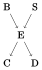

In [18]:
b = DiscreteBayesNet()
push!(b, DiscreteCPD(:B, [0.1,0.9]))
push!(b, DiscreteCPD(:S, [0.5,0.5]))
push!(b, rand_cpd!(b, 2, :E, [:B, :S]))
push!(b, rand_cpd!(b, 2, :D, [:E]))
push!(b, rand_cpd!(b, 2, :C, [:E]))

Compute 

$P(b^1, d^1, c^1) = \sum_s \sum_e P(b^1)P(s)P(e \mid b^1, s)P(d^1 \mid e)P(c^1 \mid e)$

In [19]:
a = Assignment(:B=>2, :D=>2, :C=>2)

Dict{Symbol,Any} with 3 entries:
  :C => 2
  :B => 2
  :D => 2

In [20]:
T = table(b,:B,a)*table(b,:S)*table(b,:E,a)*table(b,:D,a)*table(b,:C,a)

,B,S,E,D,C,p
1,2,1,1,2,2,0.013931813837113746
2,2,2,1,2,2,0.02326086909619555
3,2,1,2,2,2,0.09240793492892137
4,2,2,2,2,2,0.047568918875925056


In [21]:
sumout(T, [:S, :E])

,B,D,C,p
1,2,2,2,0.17716953673815572


## Approximate Inference

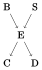

In [22]:
b = DiscreteBayesNet()
push!(b, DiscreteCPD(:B, [0.1,0.9]))
push!(b, DiscreteCPD(:S, [0.5,0.5]))
push!(b, rand_cpd!(b, 2, :E, [:B, :S]))
push!(b, rand_cpd!(b, 2, :D, [:E]))
push!(b, rand_cpd!(b, 2, :C, [:E]))

In [23]:
rand(b)

Dict{Symbol,Any} with 5 entries:
  :S => 1
  :C => 2
  :B => 1
  :D => 1
  :E => 1

In [24]:
rand(b, 8)

,B,S,E,C,D
1,2,2,1,2,2
2,2,2,2,2,1
3,2,2,1,2,1
4,2,2,1,1,1
5,2,1,2,2,1
6,2,1,2,2,1
7,2,2,1,2,1
8,2,2,1,2,1


### Example chemical detection network

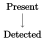

In [25]:
b = BayesNet()
push!(b, StaticCPD(:Present, Bernoulli(0.001)))
push!(b, FunctionalCPD{Bernoulli}(:Detected, [:Present], a->Bernoulli(a[:Present] == true ? 0.999 : 0.001)))

In [26]:
rand(b, 10)

,Present,Detected
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0
10,0,0


Not very interesting since all the samples are likely to be (false, false)

In [27]:
data = rand(b, 1000)
sum(data[:Detected] .== 1)

3

Even with 1000 samples, we are not likely to get many samples that are consistent with Detected = true. This can result in a pretty poor estimate.

In [28]:
estimate(rand(b, 1000, Assignment(:Detected=>true), 100000000))

,Present,Detected,p
1,0,1,0.476
2,1,1,0.524


### Likelihood weighted sampling

In [29]:
rand_table_weighted(b, nsamples=10, consistent_with=Assignment(:Detected=>true))

,Detected,Present,p
1,true,0,0.09999999999999998
2,true,0,0.09999999999999998
3,true,0,0.09999999999999998
4,true,0,0.09999999999999998
5,true,0,0.09999999999999998
6,true,0,0.09999999999999998
7,true,0,0.09999999999999998
8,true,0,0.09999999999999998
9,true,0,0.09999999999999998
10,true,0,0.09999999999999998


In [30]:
estimate(rand_table_weighted(b, nsamples=10000, consistent_with=Assignment(:Detected=>true)))

,Detected,Present,p
1,true,0,0.47616550672132874
2,true,1,0.5238344932786713
